# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* ***users***: demographic information of users.
* ***events***: events done by the users in the platform.
* ***transactions***: question and answer solved by user.

These table are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_lernnavi_sciper.ipynb). We have also provided access to a [test account to experiment with Lernnavi](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). 

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
!git clone https://GITHUB_TOKEN@github.com/davhofer/recommender.git recommender

import sys
sys.path.insert(0, '/content/recommender')

!pip install --upgrade -r recommender/requirements.txt

Cloning into 'recommender'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 218 (delta 24), reused 27 (delta 11), pack-reused 156
Receiving objects: 100% (218/218), 614.16 KiB | 3.63 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.4 MB/s eta 0:00:

In [2]:
import pandas as pd

DATA_DIR = '/content/gdrive/MyDrive' 
STUDY_DIR = DATA_DIR + '/study'

users = pd.read_csv(f'{DATA_DIR}/users.csv.gz')
documents = pd.read_csv(f'{DATA_DIR}/documents.csv.gz')

# use study for less data, for testing
events = pd.read_csv(f'{DATA_DIR}/events.csv.gz')
topics = pd.read_csv(f'{DATA_DIR}/topics_translated.csv')
transactions = pd.read_csv(f'{DATA_DIR}/transactions.csv.gz')

## Task 0: Research Question

**Research question:**
Train a recommender system that recommends the next topic a student should work on, based on the implicit feedback from previous interactions.

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [3]:
# Your code for data processing goes here

# PREPROCESS EVENTS
def preprocess_events(df, topics):
    df = df[~df['topic_id'].isna()]
    df = df[~df['session_id'].isna()]

    df['topic_id'] = df['topic_id'].astype(int)
    df['session_id'] = df['session_id'].astype(int)
    df['event_date'] = pd.to_datetime(df['event_date'])

    df['action'] = df['action'].replace('VIEW_QUESTION', 'tmp')
    df['action'] = df['action'].replace('REVIEW_TASK', 'VIEW_QUESTION')
    df['action'] = df['action'].replace('tmp', 'REVIEW_TASK')


    def first(x):
        return list(x)[0]

    # aggregators for when we do the groupby
    aggregators = {
        'event_date': 'max',
        'action': set,
        'topic_id': first,
        'category': set,
        'event_type': set,
        'session_type': first,
        'session_closed': first,
        'session_accepted': first,
        'tracking_data': list, #lambda x: list(filter(lambda y: isinstance(y, dict), x)),
    }

    interesting_cols = ['user_id', 'session_id'] + list(aggregators.keys())

    other_aggs = {}
    for c in df.columns:
        if c not in ['user_id', 'session_id'] and c not in aggregators.keys():
            other_aggs[c] = lambda x: 0

    aggregators.update(other_aggs)

    df = df.groupby(['user_id', 'session_id']).agg(aggregators).reset_index()


    # only take users with at least 5 interactions
    filter_users = df[['user_id', 'session_id']].groupby('user_id').nunique()
    filter_users = filter_users[filter_users['session_id'] >= 5]
    filter_users = filter_users.index

    df = df[df['user_id'].isin(filter_users)]

    df = df[interesting_cols]

    # identify which events belong to math topics or to german topics
    topics = topics[['id', 'math']].rename(columns={'id': 'topic_id', 'math': 'is_math'})
    df = pd.merge(left=df, right=topics, on='topic_id')

    return df


#########################################################################

events_preprocessed = preprocess_events(events, topics)
events_preprocessed.head()


,user_id,session_id,event_date,action,topic_id,category,event_type,session_type,session_closed,session_accepted,tracking_data,is_math
0,387604,22703,2021-07-02 09:42:33.225,"{VIEW_SESSION_END, REVIEW_TASK, SKIP}",2065,"{TASK, SESSION}","{VIEW, CLICK}",1.0,1.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0
1,387604,171284,2022-08-30 11:24:45.402,"{VIEW_QUESTION, VIEW_SESSION_END, REVIEW_TASK,...",2065,"{FEEDBACK, TASK, SESSION}","{VIEW, CLICK}",2.0,1.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0
2,387742,8803,2021-06-07 16:11:59.607,"{CLOSE, REVIEW_TASK}",2065,"{TASK, SESSION}","{VIEW, CLICK}",1.0,1.0,1.0,"[nan, nan, nan]",0
3,387742,35458,2021-06-07 17:33:35.568,"{SUBMIT_ANSWER, VIEW_SESSION_END, NEXT, REVIEW...",2065,"{TASK, SESSION}","{VIEW, CLICK}",1.0,1.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0
4,387742,35459,2021-06-07 17:36:08.468,"{NEXT, VIEW_SESSION_END, REVIEW_TASK, SKIP, SU...",2065,"{TASK, SESSION}","{VIEW, CLICK}",1.0,1.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0


In [4]:
# CREATE FEATURE VECTORS FOR LATER USE
import numpy as np

# helper function to add data to a dataframe
def df_add_data(df, col_name, data, fill_na_value=0, key='user_id'):
    dtype = type(data.keys()[0])
    def get_val(row):
        if dtype(row[key]) in data.keys():
            if np.isnan(data[dtype(row[key])]):
                return fill_na_value
            else:
                return data[dtype(row[key])]
        else:
            return fill_na_value
    df[col_name] = df.apply(get_val, axis=1)
    return df

# first, simple set of features that can be used to train the model. the features
# are built using the training data
def create_user_features(users, transactions):

    user_features = users[['user_id', 'gender', 'canton', 'class_level']]

    transactions = transactions[~transactions['topic_id'].isna()]
    transactions = transactions[~transactions['user_id'].isna()]

    transactions['transaction_id'] = transactions['transaction_id'].astype(int)
    transactions['user_id'] = transactions['user_id'].astype(int)

    def compute_percentage_correct(transactions_df):

        usrs = pd.DataFrame({'user_id': transactions_df['user_id'].unique(), 'dummy': transactions['user_id'].unique()})
        usrs = usrs.set_index('user_id', drop=True)

        partial_per_user = transactions_df[transactions_df['evaluation'] == 'PARTIAL'].groupby('user_id').count()['transaction_id']
        correct_per_user = transactions_df[transactions_df['evaluation'] == 'CORRECT'].groupby('user_id').count()['transaction_id']
        wrong_per_user = transactions_df[transactions_df['evaluation'] == 'WRONG'].groupby('user_id').count()['transaction_id']

        ppu_keys = partial_per_user.keys()
        cpu_keys = correct_per_user.keys()
        wpu_keys = wrong_per_user.keys()

        def correctness_score(row):
            uid = row.name
            
            n_wrong = 0 if uid not in wpu_keys else wrong_per_user[uid]
            n_partial = 0 if uid not in ppu_keys else partial_per_user[uid]
            n_correct = 0 if uid not in cpu_keys else correct_per_user[uid]

            total = n_wrong + n_correct + n_partial

            score = 100 * (n_correct + 0.5 * n_partial)


            if total == 0:
                return 0
            
            score /= total
            
            return score

        return usrs.apply(correctness_score, axis=1)

    percentage_correct = compute_percentage_correct(transactions)
    transactions = df_add_data(transactions, 'percentage_correct', percentage_correct)


    # features from transactions

    num_topics = transactions[['user_id', 'topic_id']].groupby('user_id').nunique()['topic_id']

    user_features = df_add_data(user_features, 'num_topics', num_topics)

    transactions_per_user = transactions[['transaction_id', 'user_id']]
    transactions_per_user = transactions_per_user.groupby(['user_id']).size()

    user_features = df_add_data(user_features, 'num_transactions', transactions_per_user)

    transactions_per_user_topic = transactions[['transaction_id', 'user_id', 'topic_id']]
    transactions_per_user_topic = transactions_per_user_topic.groupby(['user_id', 'topic_id'])
    per_topic_count = transactions_per_user_topic.count().reset_index()

    per_topic_count = per_topic_count[~per_topic_count['topic_id'].isna()]

    per_topic_mean = per_topic_count.groupby('user_id').mean()['transaction_id']
    per_topic_std = per_topic_count.groupby('user_id').std()['transaction_id']

    user_features = df_add_data(user_features, 'per_topic_mean', per_topic_mean)
    user_features = df_add_data(user_features, 'per_topic_std', per_topic_std)

    avg_performance = transactions[['user_id', 'percentage_correct']].groupby('user_id').mean()['percentage_correct']
    user_features = df_add_data(user_features, 'avg_performance', avg_performance)

    # transform values:
    user_features['gender'] = user_features.apply(lambda x: 1 if x['gender'] == 'MALE' else (2 if x['gender'] == 'FEMALE' else 0), axis=1)
    user_features['canton'].replace(list(user_features['canton'].unique()),
                            list(range(len(user_features['canton'].unique()))), inplace=True)

    user_features['class_level'].replace(list(user_features['class_level'].unique()),
                            list(range(len(user_features['class_level'].unique()))), inplace=True)

    # TODO: replace class level with better encoding, i.e. one-hot/embedding

    #user_features['class_level'].replace(np.nan, 'andere', inplace=True)

    # pd.get_dummies(user_features['class_level'])

    user_features = user_features.set_index('user_id')

    return user_features


def create_topic_features(topics, documents, events):

    events = events[~events['event_id'].isna()]
    events = events[~events['topic_id'].isna()]

    topic_features = topics[['id']].rename(columns={'id': 'topic_id'})

    num_documents = documents[['topic_id', 'document_id']].groupby('topic_id').count()['document_id']
    topic_features = df_add_data(topic_features, 'num_documents', num_documents, key='topic_id')
    num_events = events[['topic_id', 'event_id']].groupby('topic_id').count()['event_id']
    topic_features = df_add_data(topic_features, 'num_events', num_events, key='topic_id')

    topic_features = topic_features.set_index('topic_id')
    return topic_features


#########################################################################

user_features = create_user_features(users, transactions)
topic_features = create_topic_features(topics, documents, events)

user_features.head()

<ipython-input-4-59c6483dd8a3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.apply(get_val, axis=1)


,gender,canton,class_level,num_topics,num_transactions,per_topic_mean,per_topic_std,avg_performance
user_id,,,,,,,,
387604,0,0,0,13,298,22.923077,31.025424,80.227273
387605,0,0,0,25,212,8.480000,7.692637,71.212121
387608,0,0,0,12,87,7.250000,4.919812,90.740741
387613,0,0,0,3,11,3.666667,1.527525,100.000000
387615,1,1,1,1,6,6.000000,0.000000,83.333333


In [5]:
topic_features.head()

,num_documents,num_events
topic_id,,
1,1244,0
2,178,0
3,259,405105
109,364,6
950,31,0


## Some visualizations

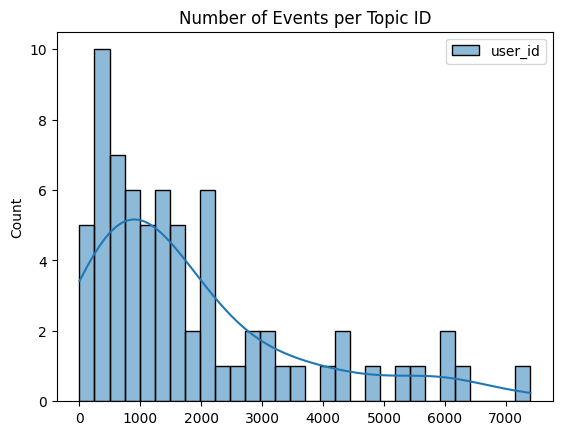

In [6]:
# Visualize for dataset with and without outliers
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outlier_IQR(df):
    data = df
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the minimum and maximum bounds for outliers
    min_bound = Q1 - 1.5 * IQR
    max_bound = Q3 + 1.5 * IQR
    return min_bound, max_bound

def visualiza_skewness(data):
    min_bound, max_bount = remove_outlier_IQR(data)
    prepro_data = data[(data>=min_bound) & (data <=max_bount)]
    plt.title("Number of Events per Topic ID")
    sns.histplot(data=pd.DataFrame(prepro_data), kde=True, bins=30, label=None)
  
df = events_preprocessed.groupby('topic_id')['user_id'].count().reset_index()
visualiza_skewness(df['user_id'])

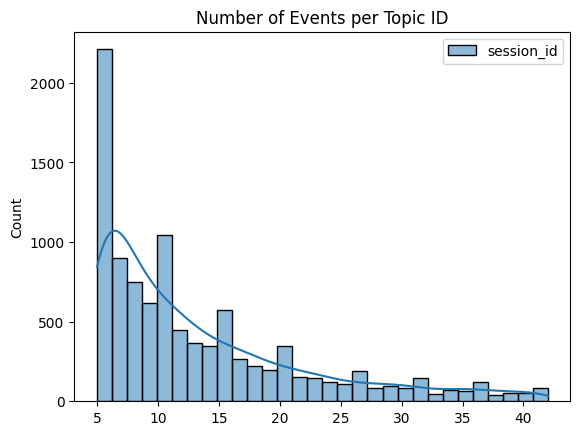

In [7]:
df = events_preprocessed.groupby('user_id')['session_id'].count().reset_index()
visualiza_skewness(df['session_id'])

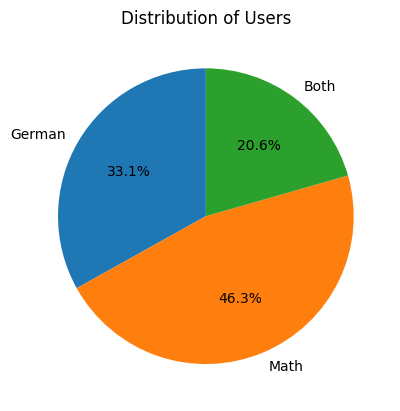

In [8]:
import matplotlib.pyplot as plt

df = events_preprocessed[['user_id', 'is_math']]
math_count = df[df['is_math']==1]['user_id'].nunique()

german_count = df[df['is_math']==0]['user_id'].nunique()
users_study_areas_count = events_preprocessed.groupby(['user_id', 'is_math']).size().index.to_frame(index=False).groupby(['user_id'])['is_math'].count()
both = len(users_study_areas_count[users_study_areas_count==2])

sizes = [math_count, german_count, both]
# Create the pie chart
labels = ['German', 'Math', 'Both']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of Users')

# Display the chart
plt.show()

We discuss the processing (and other aspects) in more detail in the report. Generally, we filtered datapoints with N/A values in relevant id columns, and grouped the datapoints such that we get interactions between users and topics. We filtered out users with too few interactions, and proceeded with the rest of the data.

## Task 2: Model Building

Train a model for your research question. 

In [9]:
# seeding everything for deterministic results

import os
import numpy as np
import torch
import random

seed = 131

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Really simple baseline model: Item-based collaborative filtering
Our first baseline model is just a simple Collaborative Filtering model that computes item similarities and computes the predicted score with inner products.  
The code of the model is adapted from: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea
 

We didn't spend much time on this model, since we were not actually considering it as an option for solving our research question, and its performance is really bad.

In [14]:
# Split the data into a "train" (interaction matrix) and test set

class ItemKNNSplitter:
    def __init__(self,
                 df,
                 test_user_frac=0.005,
                 ):
        
        events_df = df[~df['topic_id'].isna()]

        interactions = events_df[['user_id', 'topic_id', 'event_id']].groupby(['user_id', 'topic_id']).count()
        interactions = interactions[interactions['event_id'] >= 5]
        interactions_index = interactions.index

        interactions = interactions.reset_index()
        interactions = interactions.rename(columns={'event_id': 'count'})

        self.matrix = interactions.pivot_table(index='topic_id', columns='user_id', values='count')
        # self.matrix = self.matrix.subtract(self.matrix.mean(axis=1), axis=0)

        self.topics = list(self.matrix.index)

        user_ids = list(set(map(lambda x: x[0], list(interactions_index))))

        test_size = int(test_user_frac * len(user_ids))

        user_ids = random.sample(user_ids, test_size)

        self.test_samples = []

        for uid in user_ids:
            tid = random.choice(self.matrix[~self.matrix[uid].isna()].reset_index()['topic_id'])
            # val = self.matrix[uid][tid]
            self.matrix[uid][tid] = np.nan
            for t in self.topics:
                self.test_samples.append((uid, t, float(t==tid)))


   
    def get_matrix(self):
        return self.matrix

    def get_test_samples(self):
        return self.test_samples

In [15]:
import torch

class ItemKNN:
    def __init__(self, k):
        super().__init__()

        self.k = k
         
        self.predict_proba = torch.tensor([])
        

    def train(self, matrix):
        self.matrix = matrix

        self.topic_similarity = self.matrix.fillna(0).T.corr()
 
    def forward(self, user, topic):
        score = self._predict_topic_score(user, topic)
        return torch.tensor(score)

    def _predict_topic_score(self, user_id, topic_id):
        selected_user_interactions = self.matrix[user_id].to_frame('score').dropna().reset_index()
        selected_topic_similarity = self.topic_similarity[[topic_id]][topic_id].to_frame('similarity').reset_index()
        weighted_similarity = pd.merge(left=selected_user_interactions, right=selected_topic_similarity, on='topic_id', how='inner').sort_values('similarity', ascending=False)[:self.k]
        if len(weighted_similarity) == 0:
            return 0.0
        predicted_score = round(np.average(weighted_similarity['score'], weights=weighted_similarity['similarity']), 5)
        return predicted_score
    
    def test_step(self, sample):
        users, topics, y = sample 
        y_proba = self.forward(users, topics)
        self.predict_proba = torch.cat((self.predict_proba,torch.tensor([y_proba.detach().cpu()])))
    


In [16]:
itemknn_splitter = ItemKNNSplitter(events)
itemknn = ItemKNN(10)
itemknn.train(itemknn_splitter.get_matrix())

In [17]:
for sample in itemknn_splitter.get_test_samples():
    itemknn.test_step(sample)


def get_predictions(data, probas):
    return [(item[0], item[1], item[2], proba.item()) for item, proba in zip(data, probas)]

predictions = get_predictions(itemknn_splitter.get_test_samples(), itemknn.predict_proba)
predictions

[(394491, 3.0, 0.0, 62.0238),
 (394491, 109.0, 0.0, 61.5191),
 (394491, 951.0, 0.0, 61.80995),
 (394491, 952.0, 0.0, 61.71376),
 (394491, 956.0, 0.0, 61.33305),
 (394491, 957.0, 0.0, 61.63471),
 (394491, 958.0, 0.0, 62.25044),
 (394491, 962.0, 0.0, 62.75862),
 (394491, 963.0, 0.0, 57.60688),
 (394491, 964.0, 0.0, 62.35254),
 (394491, 968.0, 0.0, 61.92804),
 (394491, 970.0, 0.0, 61.49697),
 (394491, 971.0, 0.0, 62.17316),
 (394491, 972.0, 0.0, 61.68914),
 (394491, 973.0, 0.0, 62.21664),
 (394491, 974.0, 0.0, 61.36872),
 (394491, 978.0, 0.0, 62.23291),
 (394491, 986.0, 0.0, 61.08329),
 (394491, 987.0, 0.0, 62.04865),
 (394491, 992.0, 0.0, 60.75335),
 (394491, 997.0, 0.0, 61.78771),
 (394491, 1001.0, 0.0, 58.39644),
 (394491, 1002.0, 0.0, 62.80975),
 (394491, 1003.0, 0.0, 61.30391),
 (394491, 1005.0, 0.0, 56.20732),
 (394491, 1007.0, 0.0, 64.38462),
 (394491, 1010.0, 0.0, 63.17378),
 (394491, 1018.0, 0.0, 60.07833),
 (394491, 1024.0, 0.0, 61.11789),
 (394491, 1029.0, 0.0, 61.68489),
 (394

## Neural Collaborative Filtering
The more interesting model is the NCF model, adapted from https://arxiv.org/abs/1708.05031.  
This model replaces the interaction matrix with a neural network to model the relatiionship between users and topics. Our implementation allows for two "versions" of the model: one that simply uses the implicit interaction data of users and topics, and takes as input simply a user_id and a topic_id, and one that uses additional feature vectors that can be precomputed and fed into the model. The classes below support both.

Unfortunately, it seems like there are still some problems with the version that uses additional features, as in training it produces much higher losses than its "simpler" other variant.

The models are trained and evaluated with the Leave-one-out approach: the training set is all but one interaction for each user. Train the model, and then try to predict the last user-topic interaction (compared to other topics).

In [37]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class LeaveOneOutDS(Dataset):
    def __init__(self, data, user_ids, topic_ids):
        self.data = data
        self.user_ids = user_ids
        self.topic_ids = topic_ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        user, topic, features, y = self.data[index]

        user = self.user_ids.index(user)
        user = torch.tensor(user)

        topic = self.topic_ids.index(topic)
        topic = torch.tensor(topic)

        y = torch.tensor([y])
        return user, topic, features, y
    

class LeaveOneOutSplitter:
    def __init__(self,
                 df,
                 use_features=False,
                 user_features=None,
                 topic_features=None,
                 test_user_frac=0.5,
                 val_user_frac=0.5,
                 train_negative_frac=1.0,
                 test_sample_strat="newest",
                 ):
        if test_sample_strat not in ['newest', 'random']:
            print("'test_sample_strat' should either be 'newest' or 'random'!")
            return
        
        self.df = df 
        self.train_negative_frac = train_negative_frac
        self.test_sample_strat = test_sample_strat

        self.use_features = use_features
        self.user_features = user_features
        self.topic_features = topic_features

        if self.use_features:
            if self.user_features is None or self.topic_features is None:
                print("No features have been passed but use_features is True. Init failed!")
                return 
            
            self.num_user_features = self.user_features.shape[1]

            self.num_topic_features = self.topic_features.shape[1]
        
        else:
            self.num_user_features = 0
            self.num_topic_features = 0

        self.user_ids = list(df['user_id'].unique())
        self.topic_ids = list(df['topic_id'].unique())

        self.num_students = len(self.user_ids)
        self.num_topics = len(self.topic_ids)

        interactions = list(df.groupby(['user_id', 'topic_id']).count().index)

        all_pairings = {(user, topic) for user in self.user_ids for topic in self.topic_ids}
        positives = set(interactions)
        no_interaction = all_pairings - positives

        test_size = int(test_user_frac * len(self.user_ids))
        val_size = int(val_user_frac * len(self.user_ids))

        val_test_samples = []
        if self.test_sample_strat == 'random':
            for id in self.user_ids:
                user_interactions = list(filter(lambda x: x[0] == id, interactions))
                s = random.choice(user_interactions)
                val_test_samples.append(s)
        else:
            user_last_event = df[['user_id', 'event_date']].groupby('user_id').max()
            df['test_set'] = df.apply(lambda row: row['event_date'] == user_last_event['event_date'][row['user_id']], axis=1)
            val_test_samples = list(df[df['test_set']].groupby(['user_id', 'topic_id']).count().index)

        test_samples = random.sample(val_test_samples, test_size)
        self.test_data = []
        for user_id, topic_id in test_samples:
            for t in self.topic_ids:
                features = []
                if self.use_features:
                    features.append(self._get_user_feature(user_id))
                    features.append(self._get_topic_feature(t))
                label = 1.0 if topic_id == t else 0.0
                self.test_data.append((user_id, t, features, label))

        for s in self.test_data:
            t = (s[0], s[1])
            if t in val_test_samples:
                val_test_samples.remove((s[0], s[1]))

        val_samples = random.sample(val_test_samples, val_size)
        self.val_data = []
        for user_id, topic_id in val_samples:
            features = []
            if self.use_features:
                features.append(self._get_user_feature(user_id))
                features.append(self._get_topic_feature(topic_id))
            self.val_data.append((user_id, topic_id, features, 1.0))

        for s in self.test_data:
            t = (s[0], s[1])
            if t in positives:
                positives.remove((s[0], s[1]))
            if t in no_interaction:
                no_interaction.remove((s[0], s[1]))

        for s in self.val_data:
            t = (s[0], s[1])
            if t in positives:
                positives.remove((s[0], s[1]))
            if t in no_interaction:
                no_interaction.remove((s[0], s[1]))


        positives = set(interactions)
        negatives = random.sample(list(no_interaction), int(train_negative_frac*len(positives)))

        self.data = []

        for x in positives:
            features = []
            if self.use_features:
                features.append(self._get_user_feature(x[0]))
                features.append(self._get_topic_feature(x[1]))
            self.data.append((x[0], x[1], features, 1.0))

        for x in negatives:
            features = []
            if self.use_features:
                features.append(self._get_user_feature(x[0]))
                features.append(self._get_topic_feature(x[1]))
            self.data.append((x[0], x[1], features, 0.0))

            
    def get_data(self):
        return self.data

    def get_val_data(self):
        return self.val_data

    def get_test_data(self):
        return self.test_data
    

    def _get_user_feature(self, uid):
        if not self.use_features:
            return torch.Tensor()

        if uid not in self.user_features.index:
            return torch.zeros(self.num_user_features).float()

        return torch.tensor(self.user_features.loc[uid, :]).float()

    def _get_topic_feature(self, tid):
        if not self.use_features:
            return torch.Tensor()
        
        if tid not in self.topic_features.index:
            return torch.zeros(self.num_topic_features).float()

        return torch.tensor(self.topic_features.loc[tid, :]).float()

    def get_num_students(self):
        return self.num_students

    def get_num_topics(self):
        return self.num_topics

    def get_user_ids(self):
        return self.user_ids

    def get_topic_ids(self):
        return self.topic_ids

    def get_train_dataset(self):
        return LeaveOneOutDS(self.get_data(), self.get_user_ids(), self.get_topic_ids())

    def get_val_dataset(self):
        return LeaveOneOutDS(self.get_val_data(), self.get_user_ids(), self.get_topic_ids())

    def get_test_dataset(self):
        return LeaveOneOutDS(self.get_test_data(), self.get_user_ids(), self.get_topic_ids())
    

In [38]:
from torch.utils.data import DataLoader

USE_FEATURES = False

data_splitter = LeaveOneOutSplitter(
    events_preprocessed,
    use_features=USE_FEATURES,
    user_features=None,#user_features,
    topic_features=None,#topic_features,
    test_user_frac=0.01,
    val_user_frac=0.99,
    train_negative_frac=1.5,
    test_sample_strat="newest"
)


BATCH_SIZE = 64

train_dataloader = DataLoader(data_splitter.get_train_dataset(), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(data_splitter.get_val_dataset(), batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(data_splitter.get_test_dataset(), batch_size=BATCH_SIZE, shuffle=False)

In [39]:
from torch import nn, optim
import pytorch_lightning as pl



class NCFNetwork(pl.LightningModule):
    def __init__(self,
                 num_students,
                 num_topics,
                 predictive_factors=64,
                 use_features=False,
                 num_user_features=0,
                 num_topic_features=0,
                 loss=nn.BCELoss(),
                 ):
        super().__init__()

        self.use_features = use_features
        self.num_user_features = num_user_features
        self.num_topic_features = num_topic_features

        if self.use_features:
            if not (self.num_topic_features > 0 and self.num_user_features > 0):
                print("num_topic_features and num_user_features need to be greater than 0. Init failed!")
                return

        # Parameters are set up to match 3 linear layers configuration
        student_embedding_dim = 2 * predictive_factors
        topic_embedding_dim = 2 * predictive_factors

        self.student_embedding_layer = nn.Embedding(num_students, student_embedding_dim)
        self.topic_embedding_layer = nn.Embedding(num_topics, topic_embedding_dim)

        self.network = nn.Sequential(
            nn.Linear(student_embedding_dim + topic_embedding_dim + self.num_user_features + self.num_topic_features, 4 * predictive_factors),
            nn.ReLU(),
            nn.Linear(4 * predictive_factors, 2 * predictive_factors),
            nn.ReLU(),
            nn.Linear(2 * predictive_factors, predictive_factors),
            nn.ReLU(),
            nn.Linear(predictive_factors, 1),
            nn.Sigmoid(),
        )

        self.loss = loss

        self.predict_proba = torch.Tensor()
        self.loss_logs = []

        self.save_hyperparameters()

    def forward(self, student_x, topic_x, features_x):
        student_emb = self.student_embedding_layer(student_x)
        topic_emb = self.topic_embedding_layer(topic_x)

        x = torch.cat((student_emb, topic_emb, *features_x), 1)

        proba = self.network(x)

        return proba

    def training_step(self, batch, batch_idx):
        student_x, topic_x, features_x, y = batch

        y_proba = self(student_x, topic_x, features_x)

        loss = self.loss(y_proba, y)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

        self.loss_logs.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):
        student_x, topic_x, features_x, y = batch

        y_proba = self(student_x, topic_x, features_x)

        loss = self.loss(y_proba, y)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def on_test_epoch_start(self):
        self.predict_proba = torch.Tensor()

    def test_step(self, batch, batch_idx):
        student_x, topic_x, features_x, y = batch

        y_proba = self(student_x, topic_x, features_x)

        self.predict_proba = torch.cat((self.predict_proba, y_proba.detach().cpu()))

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    



In [40]:

from torch import nn


PREDICTIVE_FACTORS = 32

ncf = NCFNetwork(
    num_students=data_splitter.num_students,
    num_topics=data_splitter.num_topics,
    predictive_factors=PREDICTIVE_FACTORS,
    use_features=USE_FEATURES,
    num_user_features=0,#user_features.shape[1],
    num_topic_features=0,#topic_features.shape[1],
    loss=nn.BCELoss()
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [41]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, EarlyStopping


EPOCHS = 10

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=2,
    verbose=True,
    mode="min"
)

trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        accumulate_grad_batches=1,
        max_epochs=EPOCHS,
        callbacks=[TQDMProgressBar(refresh_rate=10), early_stop_callback],
        val_check_interval=0.5
)

trainer.fit(model=ncf, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type       | Params
-------------------------------------------------------
0 | student_embedding_layer | Embedding  | 698 K 
1 | topic_embedding_layer   | Embedding  | 5.0 K 
2 | network                 | Sequential | 26.9 K
3 | loss                    | BCELoss    | 0     
-------------------------------------------------------
730 K     Trainable params
0         Non-trainable params
730 K     Total params
2.921     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.775


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.761


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.722


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.716


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.709


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.695


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.660


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.655


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.645


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.598


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.535


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.501


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.477


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.465


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.428


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.379
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [42]:
trainer.test(model=ncf, dataloaders=test_dataloader)

Testing: 0it [00:00, ?it/s]

[{}]

In [47]:
import csv 

def get_predictions(data, probas):
    return [(item[0], item[1], item[3], proba.item()) for item, proba in zip(data, probas)]


def write_outputs(data, loss_logs, model_description, output_dir):
    probas_output_path = f"{output_dir}/{model_description}_probas.csv"

    with open(probas_output_path, 'w') as f:
        csv_out = csv.writer(f)
        csv_out.writerow(['user_id', 'topic_id', 'was_interaction', 'predict_proba'])

        for row in data:
            csv_out.writerow(row)

    loss_outputs_path = f"{output_dir}/{model_description}_loss.csv"

    with open(loss_outputs_path, 'w') as f:
        csv_out = csv.writer(f)
        csv_out.writerow(['loss_value', 'iteration'])
        for idx, loss_value in enumerate(loss_logs, 1):
            csv_out.writerow((loss_value, idx))

predictions = get_predictions(data_splitter.get_test_data(), ncf.predict_proba)
write_outputs(predictions, ncf.loss_logs, f"math-german-no-features-{PREDICTIVE_FACTORS}", '/content/gdrive/MyDrive/recommender_outputs')

For model training, we first split the data into train, validation and test sets. The validation and test set consists of interactions sampled from the last interaction of each user (Leave-one-out). The rest of the data is used for training. Here, we only used user and topic ids as inputs to the model, without additional features. The model is trained with batch size 64 for 10 epochs, and after each 0.5 epochs, the loss is computed on the validation set which we use to stop the training early if performance doesn't increase. One hyperparameter is also PREDICTVE_FACTORS, which is the size of the last hidden layer of the model. After training, we predict the output probabilities for the test set.

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [46]:
import math
import numpy as np
import pandas as pd

def HitRate(proba_all_topic_csv, n=10):
    """
    @args:
    proba_all_topic_csv: {user_id, topic_id, was_interaction, predict_proba} csv file return recommendation probability for every topic 
    n: keep top n topic recommendation

    @output:
    hit_list: (array) hit[i] == 0/1 indicates hit/miss for test sample i 
    ndcg_list: (array) ndcg[i] score for test sample ith
    """
    hit_list = []
    ndcg_list = []
    proba_all_topic_df = pd.read_csv(proba_all_topic_csv)
    user_predict = proba_all_topic_df.groupby(['user_id'])

    for user, topic in user_predict:
        #print(topic)
        # Get the top N of highest probability and rank them 
        topN = [x for _, x in sorted(zip(topic['predict_proba'], topic['topic_id']), reverse=True)][:n]
        positive_topic = int(topic[topic['was_interaction']==1]['topic_id'])
        # Calculate hit rate
        hit_list.append(getHitRatio(topN, positive_topic))
        
        # Calculate NDCG
        ndcg_list.append(getNDCG(topN, positive_topic))
        
    print(f'HR@{n}: {np.array(hit_list).mean()}, NDCG@{n}: {np.array(ndcg_list).mean()}')
    return (hit_list, ndcg_list)


def getHitRatio(ranklist, topic):
    for item in ranklist:
        if item == topic:
            return 1
    return 0

def getNDCG(ranklist, topic):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == topic:
            return math.log(2) / math.log(i+2)
    return 0


metric = HitRate(f"/content/gdrive/MyDrive/recommender_outputs/math-german-no-features-{PREDICTIVE_FACTORS}_probas.csv", 10)

HR@10: 0.4954128440366973, NDCG@10: 0.25599701309777484


<ipython-input-46-7bf1d9295872>:20: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for user, topic in user_predict:


As metrics for our model, we used the HitRatio@k and NDCG. The HitRate computes the ratio of samples where the actual topic is among the top k recommended topics. The NDCG is similar, but also takes the position of the actual topic in the ranking list into account.  

Our models usually performed reasonably well, with HitRate@10 between 0.45 and 0.6 and NDCG between 0.24 and 0.3. This means that for about 50% of the students, the actual topic they chose to work on next was among the top 10 recommended topics. This seems to be quite a good result. It definitely performs much better than the simple baseline which has below 0.1 HitRate@10, but we will try to compare it to better models in the future.



## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

The contributions were distributed more or less as follows:  
David worked on the preprocessing and data preparation, Boris on the model training as well as the data structures used for this, and Lan mostly worked on the evaluation. We often met in person and discussed problems and questions with each other frequently.  

A challenge was that the area of recommender systems was new for all of us, therefore it took quite some effort to get into the subject matter and understand the somewhat different paradigms to other fields of ML.
In the future, we could try to separate some responsabilities clearer, as there was some overlap previously which slowed us down.

## Further code for plots and analysis
Below you can find further code we used to produce graphs.

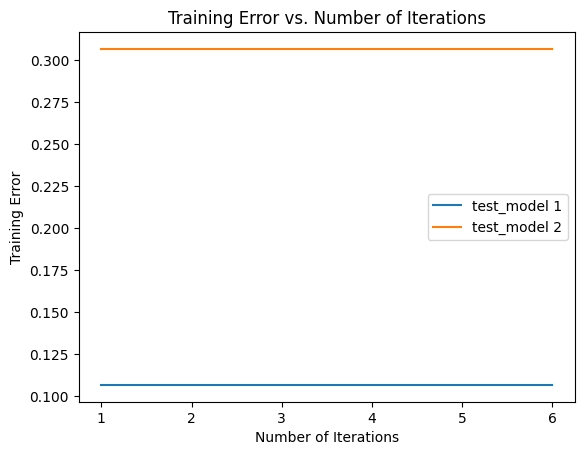

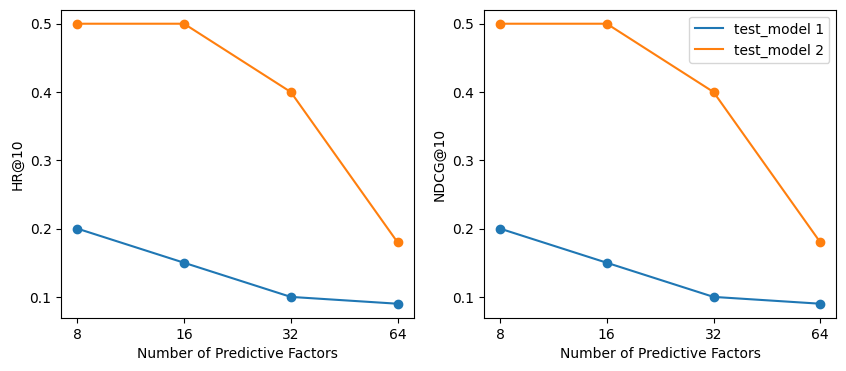

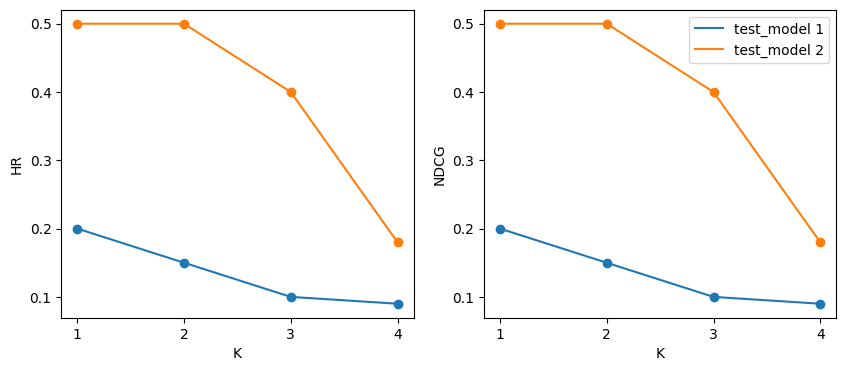

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

def iteration_error_plot(model_error_dict):
    """
    @args: 
    model_error_dict: dict {'model_name': [model_error_list, iteration]} indicates training error according to each epoch
    """

    # Compute the smoothed values of the error using a rolling mean

    batch_size = 64

    for model_name, error_log in model_error_dict.items():
        error_list, iteration = np.array(error_log[0]), np.array(error_log[1])
        for i in range(0, error_list.shape[0], batch_size):
            error_list[i: (i + batch_size)] = np.mean(error_list[i: (i + batch_size)] )        

        # Replace the original array with the means array
        plt.plot(iteration, error_list, label=model_name)
       

    # add labels and title
    plt.xlabel('Number of Iterations')
    plt.ylabel('Training Error')
    plt.title('Training Error vs. Number of Iterations')
    plt.legend()

    # display the plot
    plt.show()

def predictive_factor_eval_plot(factor_arr, hr_dict, ndcg_dict, n):
    """
    @args: 
    factor_arr: list of predictive factors of NCF model 
    hr_dict: dict {'model_name': hr_score} of hit rate score according to factor
    ndcg_dict: dict {'model_name': ndcg_score} of ndcg_arr score according to factor
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
    factor_arr = np.array(factor_arr).astype(str)

    for model_name, hr_score in hr_dict.items():
        ax1.plot(factor_arr, hr_score, label=model_name)
        ax1.scatter(factor_arr, hr_score)

    for model_name, ndcg_score in ndcg_dict.items():
        ax2.plot(factor_arr, ndcg_score, label=model_name)
        ax2.scatter(factor_arr, ndcg_score)

    # add labels and title
    ax1.set_xlabel('Number of Predictive Factors')
    ax1.set_ylabel('HR@{n}'.format(n=n))
    
    ax2.set_xlabel('Number of Predictive Factors')
    ax2.set_ylabel('NDCG@{n}'.format(n=n))
    plt.legend()
    
    # display the plot
    plt.show()


def k_eval_plot(k_arr, hr_dict, ndcg_dict, n=10):
    """
    @args: 
    k_arr: list of predictive factors of NCF model 
    hr_dict: dict {'model_name': hr_score} of hit rate score according to factor
    ndcg_dict: dict {'model_name': ndcg_score} of ndcg_arr score according to factor
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
    

    for model_name, hr_score in hr_dict.items():
        ax1.plot(k_arr, hr_score, label=model_name)
        ax1.scatter(k_arr, hr_score)

    for model_name, ndcg_score in ndcg_dict.items():
        ax2.plot(k_arr, ndcg_score, label=model_name)
        ax2.scatter(k_arr, ndcg_score)

    # add labels and title
    ax1.set_xlabel('K')
    ax1.set_ylabel('HR')
    ax1.set_xticks(k_arr)

    ax2.set_xlabel('K')
    ax2.set_ylabel('NDCG')
    ax2.set_xticks(k_arr)
    
    plt.legend()
    
    # display the plot
    plt.show()

# Toy example
# example training error values
training_error = {'test_model 1': [[0.2, 0.15, 0.1, 0.08, 0.06, 0.05], [1, 2, 3, 4, 5, 6]], 'test_model 2': [[0.5, 0.5, 0.4, 0.18, 0.16, 0.1], [1, 2, 3, 4, 5, 6]]}

iteration_error_plot(training_error)

hr_dict = {'test_model 1': [0.2, 0.15, 0.1, 0.09], 'test_model 2': [0.5, 0.5, 0.4, 0.18]}
ndcg_dict = {'test_model 1': [0.2, 0.15, 0.1, 0.09], 'test_model 2': [0.5, 0.5, 0.4, 0.18]}
factor_arr = [8, 16, 32, 64]
predictive_factor_eval_plot(factor_arr, hr_dict, ndcg_dict, n=10)

hr_dict = {'test_model 1': [0.2, 0.15, 0.1, 0.09], 'test_model 2': [0.5, 0.5, 0.4, 0.18]}
ndcg_dict = {'test_model 1': [0.2, 0.15, 0.1, 0.09], 'test_model 2': [0.5, 0.5, 0.4, 0.18]}
k_arr = [1, 2, 3, 4]
k_eval_plot(k_arr, hr_dict, ndcg_dict)


In this notebook, we only trained one model (we had other files and notebooks to do the whole training procedure) and therefore cannot reproduce the full output graphics here, but the functions below were used to produce all our visualizations.

In [51]:

factor_arr = [8, 16, 32, 64]
error_dict = {}
for factor in factor_arr:
    df = pd.read_csv(f'{DATA_DIR}/math-german-no-features-{factor}_loss.csv')
    error_dict[f'factor {factor}'] = [df['loss_value'], df['iteration']]

iteration_error_plot(error_dict)

FileNotFoundError: ignored

In [ ]:
def create_plot_predictive_factor_eval(factor_arr, n):
    hr_dict, ndcg_dict = {'ncf': [], 'itemknn':[]}, {'ncf': [], 'itemknn':[]}
    for factor in factor_arr:
        hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
        hr_dict['ncf'].append(hr)
        ndcg_dict['ncf'].append(ndcg)
        hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/itemknn_probas.csv', n)
        hr_dict['itemknn'].append(hr)
        ndcg_dict['itemknn'].append(ndcg)
    predictive_factor_eval_plot(factor_arr, hr_dict, ndcg_dict, n)

create_plot_predictive_factor_eval(factor_arr = [8, 16, 32, 64], n=5)
create_plot_predictive_factor_eval(factor_arr = [8, 16, 32, 64], n=10)


In [ ]:
def create_plot_k_eval(k_arr, factor_arr):
    hr_dict, ndcg_dict = {}, {}
    for factor in factor_arr:
        hr_dict[f'factor {factor}'] = []
        ndcg_dict[f'factor {factor}'] = []
        for n in k_arr:
            hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
            hr_dict[f'factor {factor}'].append(hr)
            ndcg_dict[f'factor {factor}'].append(ndcg)
    hr_dict[f'itemknn'], ndcg_dict[f'itemknn'] =[], []
    for n in k_arr:
            hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/itemknn_probas.csv', n)
            hr_dict[f'itemknn'].append(hr)
            ndcg_dict[f'itemknn'].append(ndcg)
    k_eval_plot(k_arr, hr_dict, ndcg_dict)

create_plot_k_eval([5, 6, 7, 8, 9, 10], [8, 16, 32, 64])
